In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [6]:
def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
                             p_emat, r_emat, ep_wt, er_wt,
                             mean_p, mean_r, alpha):

    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

    n_p_new = np.exp(n_p_exponent)
    n_r_new = np.exp(n_r_exponent)
    
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p_new / n_NS * w_p
    z[2] = n_r_new / n_NS * w_r

    return z[1] / np.sum(z)

In [7]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15
mean_p = 5000
mean_r = 10

alpha = 0.1
dist_p = []
dist_r = []
for i in range(5000):
  n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
  n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

  n_p_new = int(np.exp(n_p_exponent))
  n_r_new = int(np.exp(n_r_exponent))
  dist_p.append(n_p_new)
  dist_r.append(n_r_new)

In [8]:
alpha = 0.5
dist_p_high = []
dist_r_high = []
for i in range(5000):
  n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
  n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

  n_p_new = int(np.exp(n_p_exponent))
  n_r_new = int(np.exp(n_r_exponent))
  dist_p_high.append(n_p_new)
  dist_r_high.append(n_r_new)

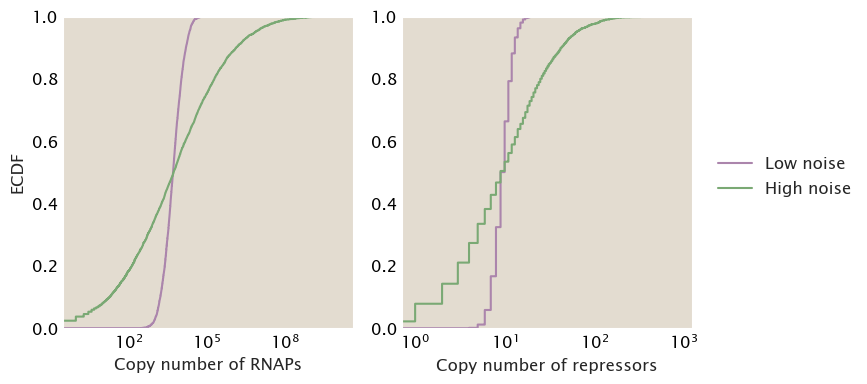

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ax1, ax2 = axes
sns.ecdfplot(dist_p, ax=ax1, label='Low noise', color='#AB85AC')
sns.ecdfplot(dist_p_high, ax=ax1, label='High noise', color='#7AA974')
ax1.set_xlabel('Copy number of RNAPs')
ax1.set_ylabel('ECDF')
ax1.set_xscale('log')

sns.ecdfplot(dist_r, ax=ax2, label='Low noise', color='#AB85AC')
sns.ecdfplot(dist_r_high, ax=ax2, label='High noise', color='#7AA974')
ax2.set_xlabel('Copy number of repressors')
ax2.set_xscale('log')
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.6, 0.6), frameon=False)

plt.tight_layout()
plt.savefig('../plots/figS8/extrinsic_noise_SI.pdf')